## In this notebook, we explore integration approximation methods for:

### Weakly singular $\iint _T g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

### Strongly singular $\iint _T \nabla g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

$\Lambda_1^E \left(\begin{bmatrix} x\\y \\0\end{bmatrix}\right) = \begin{bmatrix}x \\y \\0 \end{bmatrix}$

In [1]:
import numpy, scipy, pandas, itertools
import matplotlib.pyplot as plt

# side-by side display of pandas data frames
from IPython.display import display, HTML
CSS = """
.output {flex-direction: row;}
"""
HTML('<style>{}</style>'.format(CSS))

/usr/lib64/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/lib64/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/lib64/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/lib64/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/lib64/python2.7/site-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility

In [2]:
# define the Triangle element class with methods

class Triangle:
    def __init__(self,a,b,c):

        # initialize the vertices
        self.a = numpy.array(a)
        self.b = numpy.array(b)
        self.c = numpy.array(c)
        
        # define the Jacobian and its inverse
        self._col1 = self.a - self.c
        self._col2 = self.b - self.c
        self._col3 = numpy.cross(self._col1,self._col2)/numpy.linalg.norm(numpy.cross(self._col1,self._col2))
        self.Jac = numpy.array([self._col1,self._col2,self._col3]).T
        self.JacInv = numpy.linalg.inv(self.Jac)
        self.J = numpy.linalg.norm(numpy.cross(self._col1,self._col2))
        
        self.area = self.J/2.
        
        # initialize the quadrature points
        self.qp = []
        self.n = 0
        
    # get map from reference to this triangle
    def refToPhys(self,point):
        return numpy.dot(self.Jac, numpy.array([point[0],point[1],0])) + self.c
    
    # plot the triangle
    def plotElement(self):
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(*self.a)
        ax.scatter(*self.b)
        ax.scatter(*self.c)
        #from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        #poly3d = [1,0,0]
        #ax.add_collection3d(Poly3DCollection(poly3d, facecolors=['blue'], linewidths=1))
        plt.show()

    def setUniformQP(self,n):
        self.n = n
        refQP = [numpy.array([j+0.5,n+.5-i],float)/n for i in range(n+1) for j in range(i)]
        self.qp = [self.refToPhys(point) for point in refQP]
        return len(self.qp)
        
    def plotQP(self):
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        [ax.scatter(*point) for point in self.qp]
        plt.show()
        
    def coordsDuffy(self,t):
        t1 = t[0]
        t2 = t[1]
        return numpy.array((1.-(t1+1.)/2.)*self.c + \
                           (t1+1.)/2. * (1.- (t2+1.)/2.)*self.a + \
                           (t1+1.)*(t2+1.)*self.b/4.)

In [3]:
# kernels

# weakly singular
def greensfunction(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return numpy.exp(-1j*k*R)/(4*numpy.pi*R)

# strongly singular, coordinate-wise
def gradg_x(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return (r[0]-rp[0]) * numpy.exp(-1j*R)*(-1j*k*R - 1.)/numpy.power(R,3)

def gradg_y(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return (r[1]-rp[1]) * numpy.exp(-1j*R)*(-1j*k*R - 1.)/numpy.power(R,3)

def gradg_z(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return (r[2]-rp[2]) * numpy.exp(-1j*R)*(-1j*k*R - 1.)/numpy.power(R,3)

In [4]:
# integrate g(r,r')*div(\Lambda_1) via uniform midpoint rule
def approxUniform(T,g,rp,n,k=1):
    T.setUniformQP(n)
    value = 0.0
    for point in T.qp:
        testA = point - T.a
        testB = point - T.b
        testA = testA/numpy.linalg.norm(testA)
        testB = testB/numpy.linalg.norm(testB)
        weight = 0.0
        if numpy.dot(testA,testB) == 1. or numpy.dot(testA,testB) == -1.:
            weight = 2.*n*n
        else:
            weight = n*n
        value += g(point,rp,k)*\
            (T.JacInv[0][0]*T.Jac[0][0] + T.JacInv[1][0]*T.Jac[0][1] + T.JacInv[2][0]*T.Jac[0][2] + \
             T.JacInv[0][1]*T.Jac[1][0] + T.JacInv[1][1]*T.Jac[1][1] + T.JacInv[2][1]*T.Jac[1][2])*\
            T.J/weight
    return value

# Duffy transform approximation
def approxDuffy(T,g,rp,n,k=1):
    # determine quadrature rule for Duffy transform in the (t1,t2) coordinates
    value = 0.0
    tQP = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[0],\
                                            numpy.polynomial.legendre.leggauss(n)[0])]
    tW = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[1],\
                                            numpy.polynomial.legendre.leggauss(n)[1])]
    D1 = Triangle(T.a,T.b,rp)
    D2 = Triangle(T.b,T.c,rp)
    D3 = Triangle(T.c,T.a,rp)
    for D in [D1, D2, D3]:
        for i in range(len(tQP)):
            t1, t2 = tQP[i]
            tensorweight = tW[i][0]*tW[i][1]
            value += g(D.coordsDuffy([t1,t2]),rp,k)*\
                (T.JacInv[0][0]*T.Jac[0][0] + T.JacInv[1][0]*T.Jac[0][1] + T.JacInv[2][0]*T.Jac[0][2] + \
                 T.JacInv[0][1]*T.Jac[1][0] + T.JacInv[1][1]*T.Jac[1][1] + T.JacInv[2][1]*T.Jac[1][2])*\
                (t1+1.)/4.*D.area * tensorweight
    return  value

In [5]:
# test the Duffy transform
A = (1,1,5)
B = (0,2,5)
C = (0,1,5)
T = Triangle(A,B,C)

print '(-1,-1) got mapped to',T.coordsDuffy((-1,-1))
print '(-1, 0) got mapped to',T.coordsDuffy((-1,0))
print '(-1,+1) got mapped to',T.coordsDuffy((-1,1))

print '(+1,-1) got mapped to',T.coordsDuffy((1,-1))
print '(+1, 0) got mapped to',T.coordsDuffy((1,0))
print '(+1,+1) got mapped to',T.coordsDuffy((1,1))

print 'area is',T.area

(-1,-1) got mapped to [0. 1. 5.]
(-1, 0) got mapped to [0. 1. 5.]
(-1,+1) got mapped to [0. 1. 5.]
(+1,-1) got mapped to [1. 1. 5.]
(+1, 0) got mapped to [0.5 1.5 5. ]
(+1,+1) got mapped to [0. 2. 5.]
area is 0.5


/usr/lib64/python2.7/site-packages/matplotlib/collections.py:526: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


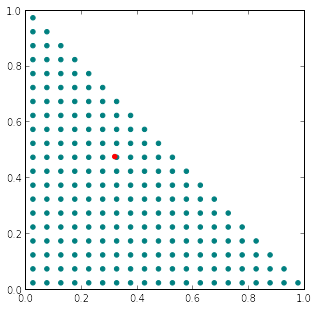

In [6]:
%matplotlib inline
A = (1,0,0)
B = (0,1,0)
C = (0,0,0)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1.5/numpy.pi))

T.setUniformQP(20)
plt.figure(figsize=(5,5))
for point in T.qp:
    plt.scatter(point[0],point[1],color='teal')
plt.scatter(rp[0],rp[1],color='red')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

### Weakly singular $\iint _T g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

#### test under translation and rotation

In [7]:
# apply the uniform midpoint rule for approximation
A = (1.0,0.0,0.0)
B = (0.0,1.0,0.0)
C = (0.0,0.0,0.0)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1./numpy.pi))
maxLevel = 200
steps = 15

results = [approxUniform(T,greensfunction,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [8]:
# check the result under the translation y+=1, z+=5
A = (1.0,0.1,1.3)
B = (0.0,1.1,1.3)
C = (0.0,0.1,1.3)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1./numpy.pi))
maxLevel = 200
steps = 15

results = [approxUniform(T,greensfunction,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniformTest1 = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniformTest1.columns = ['Unif Real', 'Unif Imag']
dataUniformTest1.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [9]:
# check the result under a rotation (by pi/4 radians about the y-axis)
A = (numpy.sqrt(2.)/2.,0.0,numpy.sqrt(2.)/2.)
B = (0.0,1.0,0.0)
C = (0.0,0.0,0.0)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1./numpy.pi))
maxLevel = 200
steps = 15

results = [approxUniform(T,greensfunction,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniformTest2 = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniformTest2.columns = ['Unif Real', 'Unif Imag']
dataUniformTest2.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [10]:
display(dataUniform)
display(dataUniformTest1)
display(dataUniformTest2)

,Unif Real,Unif Imag
1,0.599069,-0.157409
120,0.366990,-0.080493
435,0.369384,-0.079293
946,0.373599,-0.078655
1653,0.369015,-0.078557
2628,0.369615,-0.078527
3741,0.375913,-0.078359
5050,0.370567,-0.078388
6555,0.372164,-0.078395
8256,0.371913,-0.078467


,Unif Real,Unif Imag
1,0.299534,-0.078705
120,0.366182,-0.080472
435,0.368323,-0.078842
946,0.373008,-0.078483
1653,0.368833,-0.078486
2628,0.369273,-0.078422
3741,0.376040,-0.078392
5050,0.370413,-0.078326
6555,0.372010,-0.078319
8256,0.371540,-0.078303


,Unif Real,Unif Imag
1,0.599069,-0.157409
120,0.368883,-0.080546
435,0.369689,-0.079130
946,0.373642,-0.078696
1653,0.369173,-0.078516
2628,0.369608,-0.078485
3741,0.376450,-0.078509
5050,0.370653,-0.078433
6555,0.372148,-0.078362
8256,0.371825,-0.078403


#### compare midpoint uniform approx to Duffy transform approximation

In [11]:
# apply the uniform midpoint rule for approximation
A = (.1,0.,0.)
B = (0.,.13,0.)
C = (0.,0.,.2)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1.5/numpy.pi))
maxLevel = 80
steps = 15

results = [approxUniform(T,greensfunction,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [12]:
# apply the Duffy transform for approximation
A = (.1,0.,0.)
B = (0.,.13,0.)
C = (0.,0.,.2)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1.5/numpy.pi))
maxLevel = 20
steps = 15

results = [approxDuffy(T,greensfunction,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataDuffy = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffy.columns = ['Duffy Real', 'Duffy Imag']
dataDuffy.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [13]:
display(dataUniform)
display(dataDuffy)

,Unif Real,Unif Imag
1,0.062613,-0.002807
21,0.065910,-0.002884
78,0.066759,-0.002845
153,0.067972,-0.002835
276,0.068890,-0.002822
435,0.070433,-0.002819
595,0.070742,-0.002815
820,0.070001,-0.002813
1081,0.069616,-0.002822
1326,0.069678,-0.002814


,Duffy Real,Duffy Imag
3,0.082726,-0.002807
12,0.069525,-0.002806
27,0.069596,-0.002806
75,0.070274,-0.002806
108,0.070353,-0.002806
147,0.070395,-0.002806
243,0.070373,-0.002806
300,0.070370,-0.002806
363,0.070369,-0.002806
507,0.070369,-0.002806


#### performance profiling

In [14]:
# that required this many quadrature points
n=20 # for uniform
print 'unif  approx:',len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]),\
    'with approx value', approxUniform(T,greensfunction,rp,n)
n = 8 # for Duffy
print 'Duffy approx:',3*len(numpy.polynomial.legendre.leggauss(int(n))[0])**2,\
    'with approx value', approxDuffy(T,greensfunction,rp,n)

unif  approx: 210 with approx value (0.0771849182219006-0.0028126550785699377j)
Duffy approx: 192 with approx value (0.07035647280211464-0.0028056402848926705j)


In [15]:
%%timeit
n = 20
approxUniform(T,greensfunction,rp,n)

100 loops, best of 3: 6.37 ms per loop


In [16]:
%%timeit
n = 8
approxDuffy(T,greensfunction,rp,n)

100 loops, best of 3: 6 ms per loop


In [17]:
# that required this many quadrature points
n = 17 # for uniform
print 'unif  approx:',len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]),\
    'with approx value', approxUniform(T,greensfunction,rp,n)
n = 6 # for Duffy
print 'Duffy approx:',3*len(numpy.polynomial.legendre.leggauss(int(n))[0])**2,\
    'with approx value', approxDuffy(T,greensfunction,rp,n)

unif  approx: 153 with approx value (0.06797224381048382-0.0028347664800289097j)
Duffy approx: 108 with approx value (0.07035346723679367-0.002805640284892671j)


In [18]:
%%timeit
n = 17
approxUniform(T,greensfunction,rp,n)

100 loops, best of 3: 5.21 ms per loop


In [19]:
%%timeit
n = 6
approxDuffy(T,greensfunction,rp,n)

100 loops, best of 3: 4.39 ms per loop


### Strongly singular $\iint _T \nabla g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

In [20]:
A = (0.2,0,0)
B = (0,0.2,0)
C = (0,0,0.2)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1.5/numpy.pi))

freqHz     = 30e6;
eps0       = 8.85418781761e-12;
mu0        = numpy.pi*4e-7;
c_light    = 1./numpy.sqrt(eps0*mu0);
wavelength = c_light/freqHz;
#eta        = numpy.sqrt(mu0/eps0);
#omega      = 2*numpy.pi*freqHz;
k0         = 2.*numpy.pi/wavelength;

### x- component

In [21]:
# apply the uniform midpoint rule for approximation
maxLevel = 400
steps = 15
results = [approxUniform(T,gradg_x,rp,int(i),k0)/(4*numpy.pi) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [22]:
# apply the Duffy transform for approximation
maxLevel = 100
steps = 15
results = [approxDuffy(T,gradg_x,rp,int(i),k0)/(4*numpy.pi) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffy = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffy.columns = ['Duffy Real part', 'Duffy Imag']
dataDuffy.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [23]:
# Duffy transform and singularity extraction approximation
def approxDuffySingEx_x(T,g,rp,n,k=1):
    value = 0.0
    # triangular subdivision
    D1 = Triangle(T.a,T.b,rp)
    D2 = Triangle(T.b,T.c,rp)
    D3 = Triangle(T.c,T.a,rp)
#    D1 = Triangle(rp,T.a,T.b)
#    D2 = Triangle(rp,T.b,T.c)
#    D3 = Triangle(rp,T.c,T.a)
    # auxiliary functions
    dxp_dt1 = lambda D,t1,t2 : -0.5*D.c[0] + 0.5*(1.-(t2+1.)/2.)*D.a[0] + (t2+1.)/4.*D.b[0]
    dyp_dt1 = lambda D,t1,t2 : -0.5*D.c[1] + 0.5*(1.-(t2+1.)/2.)*D.a[1] + (t2+1.)/4.*D.b[1]
    dzp_dt1 = lambda D,t1,t2 : -0.5*D.c[2] + 0.5*(1.-(t2+1.)/2.)*D.a[2] + (t2+1.)/4.*D.b[2]
    fk = lambda D,t2 : numpy.linalg.norm([dxp_dt1(D,-1,t2), dyp_dt1(D,-1,t2), dzp_dt1(D,-1,t2)])
    fkcubed = lambda D,t2 : numpy.power(fk(D,t2),3.)
    # regular part
    t1t2QP = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[0],\
                                           numpy.polynomial.legendre.leggauss(n)[0])]
    t1t2W = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[1],\
                                          numpy.polynomial.legendre.leggauss(n)[1])]
    model = lambda D,t1,t2 : 1./((t1+1.) * fkcubed(D,t2)) * dxp_dt1(D,-1,t2)
    kernel = lambda D,t1,t2 : g(D.coordsDuffy([t1,t2]),rp,k) * (t1 + 1.)
    extracted = lambda D,t1,t2 : model(D,t1,t2) + kernel(D,t1,t2)
    for D in [D1, D2, D3]:
        for i in range(len(t1t2QP)):
            t1, t2 = t1t2QP[i]
            tensorweight = t1t2W[i][0]*t1t2W[i][1]
            value += 1./(16.*numpy.pi) * D.area * extracted(D,t1,t2)*\
                     (T.JacInv[0][0]*T.Jac[0][0] + T.JacInv[1][0]*T.Jac[0][1] + T.JacInv[2][0]*T.Jac[0][2] + \
                      T.JacInv[0][1]*T.Jac[1][0] + T.JacInv[1][1]*T.Jac[1][1] + T.JacInv[2][1]*T.Jac[1][2])*\
                     tensorweight
    # singular part
    t2QP = numpy.polynomial.legendre.leggauss(n)[0]
    t2W = numpy.polynomial.legendre.leggauss(n)[1]
    for D in [D1, D2, D3]:
        for i in range(len(t2QP)):
            t2 = t2QP[i]
            value += -1./(16.*numpy.pi) * D.area * \
                     1./fkcubed(D,t2) * dxp_dt1(D,-1.,t2) * numpy.log(2. * fk(D,t2)) * \
                     (T.JacInv[0][0]*T.Jac[0][0] + T.JacInv[1][0]*T.Jac[0][1] + T.JacInv[2][0]*T.Jac[0][2] + \
                      T.JacInv[0][1]*T.Jac[1][0] + T.JacInv[1][1]*T.Jac[1][1] + T.JacInv[2][1]*T.Jac[1][2])*\
                     t2W[i]
    return value

In [24]:
# apply the Duffy transform and singularity extraction for approximation
maxLevel = 100
steps = 15
results = [approxDuffySingEx_x(T,gradg_x,rp,int(i),k0) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffySing = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffySing.columns = ['Duf & SingEx Real part', 'Duf & SingEx Imag']
dataDuffySing.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [25]:
display(dataUniform)
display(dataDuffy)
display(dataDuffySing)

,Unif Real,Unif Imag
1,-2.428391,0.049494
435,-0.671726,0.000786
1711,-0.637498,0.000280
3741,-0.061272,0.000087
6670,0.082977,0.000001
10296,0.184767,0.000005
14878,0.532336,-0.000067
20100,3.883276,-0.000289
26335,0.746357,-0.000080
33153,0.152480,-0.000007


,Duffy Real part,Duffy Imag
3,0.277336,-0.001576
192,0.003480,-0.000013
675,-0.000106,-0.000008
1452,-0.000013,-0.000008
2523,-0.000012,-0.000008
3888,-0.000012,-0.000008
5547,-0.000012,-0.000008
7500,-0.000012,-0.000008
9747,-0.000012,-0.000008
12288,-0.000012,-0.000008


,Duf & SingEx Real part,Duf & SingEx Imag
3,-0.264155,-0.001576
192,0.011556,-0.000013
675,0.013937,-0.000008
1452,0.013885,-0.000008
2523,0.013884,-0.000008
3888,0.013884,-0.000008
5547,0.013884,-0.000008
7500,0.013884,-0.000008
9747,0.013884,-0.000008
12288,0.013884,-0.000008


### asymptotics analysis of the singularity and its extraction via the singular model

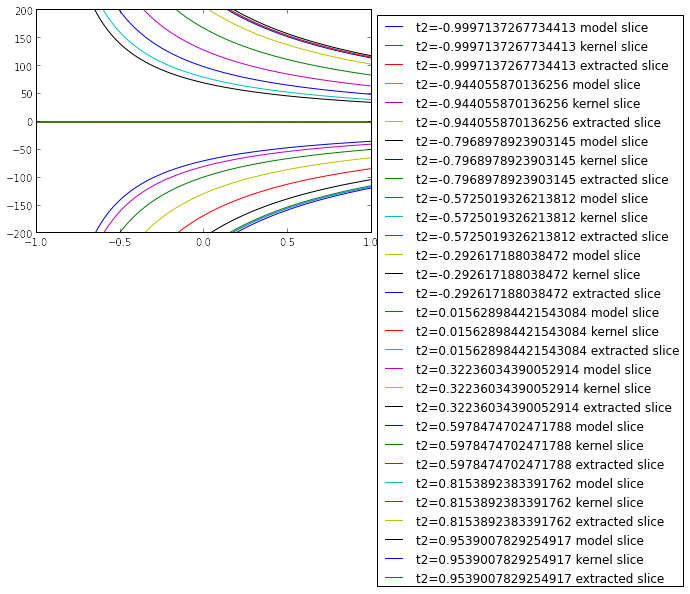

In [26]:
# auxiliary functions
dxp_dt1 = lambda D,t1,t2 : -0.5*D.c[0] + 0.5*(1.-(t2+1.)/2.)*D.a[0] + (t2+1.)/4.*D.b[0]
dyp_dt1 = lambda D,t1,t2 : -0.5*D.c[1] + 0.5*(1.-(t2+1.)/2.)*D.a[1] + (t2+1.)/4.*D.b[1]
dzp_dt1 = lambda D,t1,t2 : -0.5*D.c[2] + 0.5*(1.-(t2+1.)/2.)*D.a[2] + (t2+1.)/4.*D.b[2]
fk = lambda D,t2 : numpy.linalg.norm([dxp_dt1(D,-1,t2), dyp_dt1(D,-1,t2), dzp_dt1(D,-1,t2)])
fkcubed = lambda D,t2 : numpy.power(fk(D,t2),3.)
    
#T = Triangle((.2,0,0),(0,.2,0),(0,0,0))
T = Triangle((0.13,-0.02,0),\
             (0.13,+0.15,0),\
             (0,0,0))
rp = (0,0,0)

# singular integrand (kernel), model, and extraction result
model = lambda D,t1,t2 : 1./((t1+1.) * fkcubed(D,t2)) * dxp_dt1(D,-1,t2)
kernel = lambda D,t1,t2 : gradg_x(D.coordsDuffy([t1,t2]),rp,k0) * (t1 + 1.)
extracted = lambda D,t1,t2 : model(D,t1,t2) + kernel(D,t1,t2)

# plot slices over the interval t1 \in (-1,1) with t2 fixed
t1array = numpy.polynomial.legendre.leggauss(100)[0]
t2array = numpy.polynomial.legendre.leggauss(100)[0]

for t2 in list(t2array)[::10]:
    plt.plot(t1array, [numpy.real(model(T,p,t2)) for p in t1array],label='t2='+str(t2)+' model slice')
    plt.plot(t1array, [numpy.real(kernel(T,p,t2)) for p in t1array],label='t2='+str(t2)+' kernel slice')
    plt.plot(t1array, [numpy.real(extracted(T,p,t2)) for p in t1array],label='t2='+str(t2)+' extracted slice')

plt.xlim([-1,1])
plt.ylim([-200,200])
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

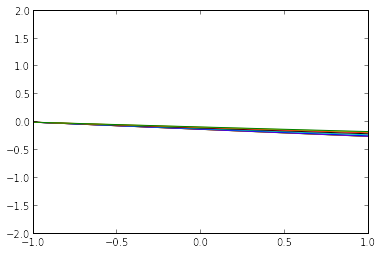

In [27]:
for t2 in list(t2array)[::10]:
    plt.plot(t1array, [numpy.real(model(T,p,t2)) for p in t1array],label='t2='+str(t2)+' model slice')
    plt.plot(t1array, [numpy.real(kernel(T,p,t2)) for p in t1array],label='t2='+str(t2)+' kernel slice')
    plt.plot(t1array, [numpy.real(extracted(T,p,t2)) for p in t1array],label='t2='+str(t2)+' extracted slice')

plt.xlim([-1,1])
plt.ylim([-2,2])
plt.show()

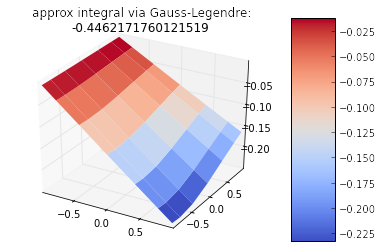

In [28]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

t1array, w1array = numpy.polynomial.legendre.leggauss(7)
t2array, w2array = numpy.polynomial.legendre.leggauss(7)

X = t1array
Y = t2array
X, Y = np.meshgrid(X, Y)
Z = 0.0*X
I = 0.0*X

for i in range(len(t1array)):
    for j in range(len(t2array)):
        Z[j][i] = numpy.real(extracted(T,t1array[i],t2array[j]))
        I[j][i] = Z[j][i]*w1array[i]*w2array[j]
        
fig = plt.figure()
ax = fig.gca(projection='3d')
#surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='coolwarm', linewidth=0, antialiased=False)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='coolwarm', linewidth=0, antialiased=True)
#ax.set_zlim(-1.01, 1.01)

fig.colorbar(surf, aspect=5)
plt.title('approx integral via Gauss-Legendre:\n'+str(numpy.sum(I)))
plt.show()

In [29]:
for n in list(numpy.linspace(2,100,10)):

    t1array, w1array = numpy.polynomial.legendre.leggauss(int(n))
    t2array, w2array = numpy.polynomial.legendre.leggauss(int(n))

    X = t1array
    Y = t2array
    X, Y = np.meshgrid(X, Y)
    Z = 0.0*X

    for i in range(len(t1array)):
        for j in range(len(t2array)):
            Z[j][i] = numpy.real(extracted(T,t1array[i],t2array[j]))*w1array[i]*w2array[j]
            
    print numpy.sum(Z),'using n=',int(n)

-0.4466584339693185 using n= 2
-0.44621717371656033 using n= 12
-0.4462171737165894 using n= 23
-0.4462171737164618 using n= 34
-0.44621717371652647 using n= 45
-0.44621717371674974 using n= 56
-0.44621717371651753 using n= 67
-0.44621717371663383 using n= 78
-0.4462171737165246 using n= 89
-0.44621717371659575 using n= 100


### y- component

### z- component